# How to crawling? - Naver Real Estate Map

In [1]:
#import custom module
import nre.con as nc
import nre.util as nu
from IPython.display import clear_output 
from matplotlib import pyplot as plt
import seaborn as sns
import cv2

sns.set(rc={'figure.figsize':(11.7,8.27)})

nu.IS_LOGGING = False

## 위치을 이용하여 구역 특정

In [2]:
#loc = nc.NLocation(35.18213, 128.1366) # 진주 충무공동
loc = nc.NLocation(37.49911, 127.065463) # 강남 대치동

#https://new.land.naver.com/complexes?ms=37.49911,127.065463,16&a=APT:OPST&b=B1:A1&e=RETAIL&s=EE

cur_region = nc.NRegion('', loc, '0000000000')

# 검색해서 지역 찾기
# while True:
#     regions = nu.get_region_list(cur_region.no)
#     if len(regions) == 0: break
#     for i, region in enumerate(regions): 
#         print(i, region)
        
#     idx = int(input("원하는 도시 인덱스(exit -1) : "))
#     clear_output()
#     if idx == -1: break
#     cur_region = regions[idx]

서울시 강남구 대치동 1168010600 loc(37.499110 | 127.065463)


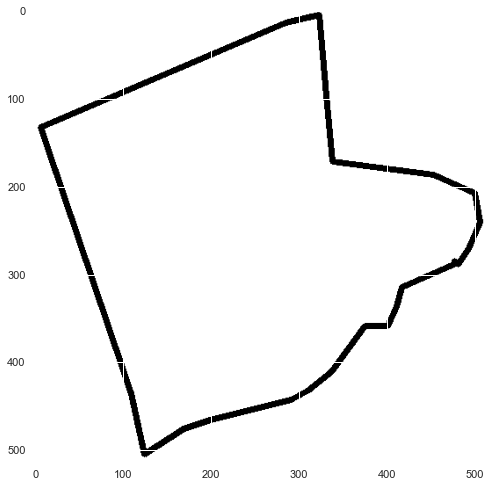

In [3]:
sector = nu.get_sector(cur_region.loc)
dm = sector.map.get_dimension()
print(sector)

plt.imshow(cv2.rotate(dm.get_bg_img(), cv2.ROTATE_90_COUNTERCLOCKWISE))

## 매물 조건 생성

In [4]:
addon = nc.NAddon(
    #direction=nc.NAddon.DIR_EACH, #전 방향 탐색의 경우 사용 - 아래 로직을 바꾸세요
    tradeType=[nc.NAddon.TRADE_DEAL, nc.NAddon.TRADE_LEASE], #목표 거래 - 매매, 전세
    estateType=[nc.NAddon.ESTATE_APT, nc.NAddon.ESTATE_OPST] #목표 매물 - 아파트, 오피스텔
)

## 조건과 구역을 이용하여 매물 탐색

In [5]:
things = [] # 매물
removed = 0
for dirr in nc.NAddon.DIR_EACH: # 모든 방향 (남향 등등)
    addon.dir = dirr # 방향 조건 선택
    things.extend(nu.get_things(sector, addon)) # 매물 저장
print('매물 수', len(things))

매물 수 142


## 구역 주변 편의 시설 탐색

In [6]:
neighbors = [] # 편의시설 기록
for nType in nc.NNeighbor.EACH: # 모든 편의시설
    values = nu.get_neighborhood(sector, nType)
    neighbors.extend(values)
    print(nType, len(values))
print('Total', len(neighbors))

BUS 59
METRO 3
INFANT 41
PRESCHOOL 5
SCHOOLPOI 8
HOSPITAL 0
PARKING 77
MART 14
CONVENIENCE 87
WASHING 43
BANK 45
OFFICE 9
Total 391


# 편의시설과 매물 간의 거리 탐색

In [7]:
# 500 == 걸어서 5~10분 이내, 버스로 1분
# 1000 == 버스로 1~2분 

standard = nu.get_distance_standard() # 거리 기준

for (key, value) in standard.items():
    print(key, value, 'm')

nu.update_things_intersection(things, neighbors, standard)

BUS 500 m
METRO 500 m
INFANT 750 m
PRESCHOOL 750 m
PRI_SCHOOL 1000 m
PUB_SCHOOL 1000 m
HOSPITAL 2000 m
PARKING 500 m
MART 500 m
CONVENIENCE 300 m
WASHING 500 m
BANK 750 m
OFFICE 1500 m


## 시각화

Dusts 533
APT	(0, 255, 0)
ABYG	(0, 255, 0)
OPST	(255, 0, 0)
OBYG	(255, 0, 0)
JGB	(0, 0, 255)
JGC	(0, 0, 255)
BUS	(0, 255, 255)
METRO	(0, 255, 255)
INFANT	(255, 255, 0)
PRESCHOOL	(255, 255, 0)
PRI_SCHOOL	(0, 0, 0)
PUB_SCHOOL	(0, 0, 0)
HOSPITAL	(0, 0, 0)
PARKING	(0, 0, 0)
MART	(0, 0, 0)
CONVENIENCE	(0, 0, 0)
WASHING	(0, 0, 0)
BANK	(0, 0, 0)
OFFICE	(0, 0, 0)


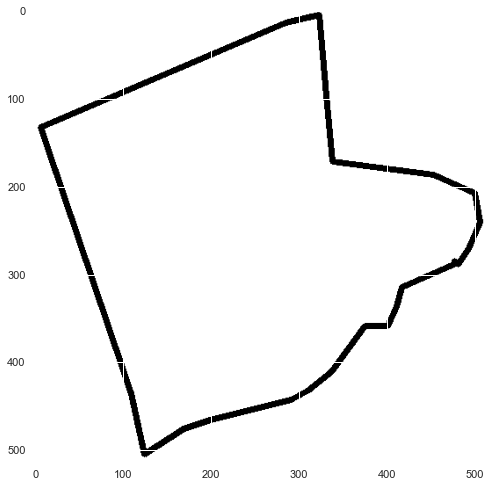

In [8]:
dm = sector.map.get_dimension()

dusts = nu.neighbors_to_dusts(neighbors, dm) # lat, lon -> 좌표 축소
dusts.extend(nu.things_to_dusts(things, dm)) # lat, lon -> 좌표 축소

color_tag = nc.NDimension.get_default_tag_color() # tag에 컬러를 연결

print('Dusts', len(dusts))
for key,value in color_tag.items():
    print(key, value, sep='\t')

plt.imshow(cv2.rotate(dm.get_img(dusts, color_tag), cv2.ROTATE_90_COUNTERCLOCKWISE)) # 출력

## Dataframe

In [10]:
import pandas as pd

def old_classifier(x): #old 구분
    value = abs(int(x[0:4]) - 2022)
    if value <= 5:
        return 'New'
    elif value <= 10:
        return 'Common'
    return 'Old'

In [11]:
total_df = pd.DataFrame(data=[t.get_list() for t in things], columns=nc.NThing.HEADER)
total_df['Old'] = total_df['Build'].apply(old_classifier)
total_df['sector'] = sector.name
total_df['city'] = sector.city

total_df

,Name,Type,Build,Dir,minArea,maxArea,representativeArea,floorAreaRatio,minDeal,maxDeal,...,MART,CONVENIENCE,WASHING,BANK,OFFICE,PRI_SCHOOL,PUB_SCHOOL,Old,sector,city
0,세영팔래스,APT,200201,EE,73.77,103.37,103.0,237,175000.0,200000.0,...,1,12,12,34,7,1,2,Old,대치동,서울시
1,삼환SOGOOD(주상복합),APT,200611,EE,107.38,133.52,133.0,359,220000.0,220000.0,...,4,11,10,35,6,1,4,Old,대치동,서울시
2,대치대우아이빌명문가(주상복합),APT,200402,EE,41.88,53.58,41.0,637,31000.0,38000.0,...,3,16,9,18,6,1,1,Old,대치동,서울시
3,대치대우아이빌명문가,OPST,200402,EE,57.05,59.01,57.0,637,31000.0,32000.0,...,3,16,9,18,6,1,1,Old,대치동,서울시
4,동양,APT,199901,EE,112.14,112.14,112.0,223,NaN,NaN,...,4,10,12,24,6,1,1,Old,대치동,서울시
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137,동양,APT,199901,WN,112.14,112.14,112.0,223,NaN,NaN,...,4,10,12,24,6,1,1,Old,대치동,서울시
138,대치클래시아,OPST,201512,WN,42.36,61.63,61.0,0,51000.0,65000.0,...,4,7,8,29,8,1,4,Common,대치동,서울시
139,바실리체,OPST,202203,WN,67.34,153.29,67.0,799,86000.0,370000.0,...,2,8,8,18,6,1,1,New,대치동,서울시
140,청원,APT,200502,WN,114.52,114.72,114.0,260,NaN,NaN,...,5,13,12,36,6,1,4,Old,대치동,서울시


In [12]:
total_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142 entries, 0 to 141
Data columns (total 38 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Name                142 non-null    object 
 1   Type                142 non-null    object 
 2   Build               142 non-null    object 
 3   Dir                 142 non-null    object 
 4   minArea             142 non-null    object 
 5   maxArea             142 non-null    object 
 6   representativeArea  142 non-null    float64
 7   floorAreaRatio      142 non-null    int64  
 8   minDeal             127 non-null    float64
 9   maxDeal             127 non-null    float64
 10  medianDeal          127 non-null    float64
 11  minLease            120 non-null    float64
 12  maxLease            120 non-null    float64
 13  medianLease         103 non-null    float64
 14  minDealUnit         127 non-null    float64
 15  maxDealUnit         127 non-null    float64
 16  medianDe

In [13]:
total_df.describe()

,representativeArea,floorAreaRatio,minDeal,maxDeal,medianDeal,minLease,maxLease,medianLease,minDealUnit,maxDealUnit,...,PRESCHOOL,HOSPITAL,PARKING,MART,CONVENIENCE,WASHING,BANK,OFFICE,PRI_SCHOOL,PUB_SCHOOL
count,142.000000,142.000000,127.000000,127.000000,127.000000,120.000000,120.000000,103.000000,127.000000,127.000000,...,142.000000,142.0,142.000000,142.000000,142.000000,142.000000,142.000000,142.000000,142.000000,142.000000
mean,99.070423,354.549296,177212.598425,246629.921260,192350.393701,107439.583333,153129.166667,123475.728155,5654.574803,6537.519685,...,2.056338,0.0,18.584507,2.943662,10.345070,9.281690,25.690141,6.605634,0.978873,2.112676
std,43.509785,251.068344,120745.214498,169392.087817,132534.924492,70064.383625,101186.957671,79838.819820,2496.299991,2807.494556,...,0.920797,0.0,5.943282,1.433018,5.038921,2.337988,7.161939,1.010286,0.144316,1.310615
min,32.000000,0.000000,26000.000000,29000.000000,27750.000000,19000.000000,19000.000000,23000.000000,1569.000000,1846.000000,...,1.000000,0.0,4.000000,0.000000,0.000000,4.000000,13.000000,5.000000,0.000000,0.000000
25%,67.000000,243.000000,71500.000000,107500.000000,78625.000000,65000.000000,70000.000000,67500.000000,3474.500000,4011.000000,...,1.000000,0.0,16.000000,2.000000,7.000000,8.000000,19.000000,6.000000,1.000000,1.000000
50%,94.000000,267.500000,185000.000000,220000.000000,185000.000000,100000.000000,117500.000000,110000.000000,5797.000000,6494.000000,...,2.000000,0.0,19.000000,3.000000,11.000000,9.000000,25.000000,6.000000,1.000000,2.000000
75%,124.000000,434.000000,252500.000000,370000.000000,260000.000000,140000.000000,220000.000000,162500.000000,7988.500000,8531.000000,...,3.000000,0.0,23.000000,4.000000,14.000000,10.750000,31.000000,7.000000,1.000000,3.000000
max,225.000000,1096.000000,505000.000000,560000.000000,510000.000000,450000.000000,450000.000000,450000.000000,10093.000000,11702.000000,...,4.000000,0.0,34.000000,6.000000,19.000000,16.000000,40.000000,9.000000,1.000000,5.000000


## 시각화 라벨

In [14]:
target_lbl = 'minLease'

## 방향에 따른 가격

<AxesSubplot:xlabel='Dir', ylabel='minLease'>

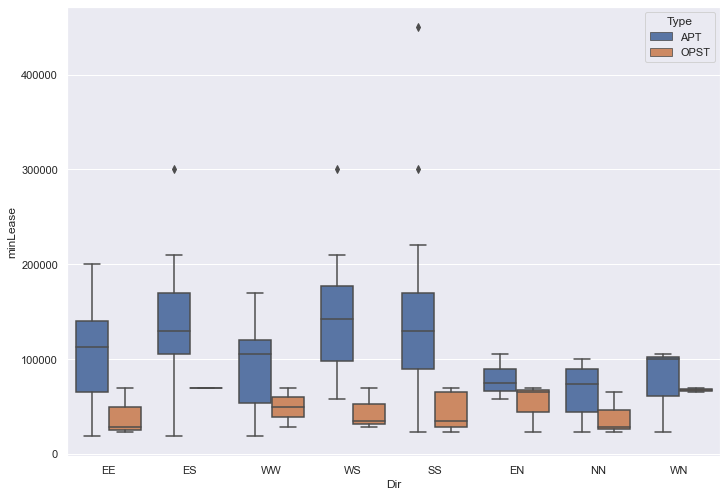

In [15]:
sns.boxplot(x='Dir', y = target_lbl, hue='Type', data=total_df)

## 오피스텔과 아파트 차이

<AxesSubplot:xlabel='Type', ylabel='minLease'>

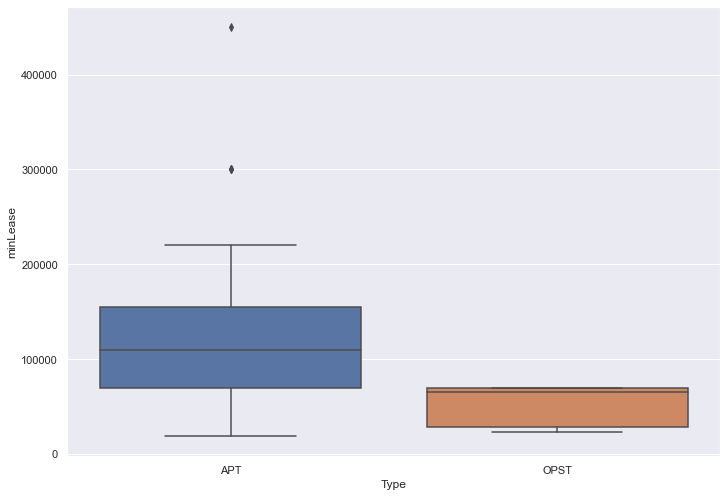

In [16]:
sns.boxplot(x='Type', y = target_lbl, data=total_df)

## 연식에 따른 차이

<AxesSubplot:xlabel='Old', ylabel='minLease'>

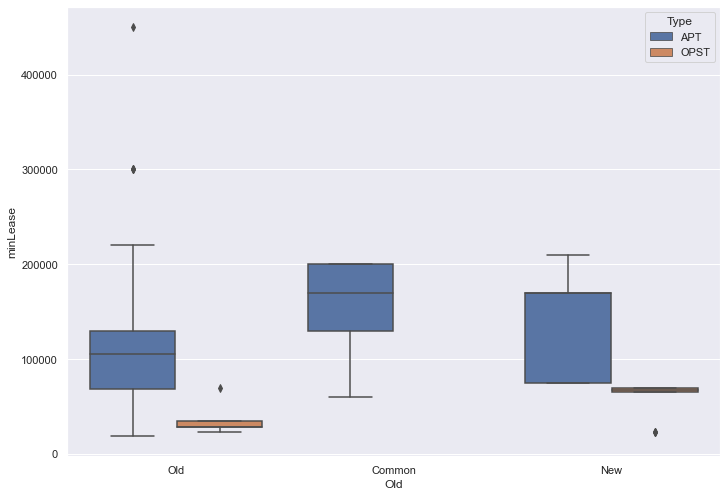

In [17]:
sns.boxplot(x='Old', y = target_lbl, hue='Type', data=total_df)

## 저장

In [18]:
total_df.to_csv('./csv/%s - %s house_price.csv' % (sector.name, sector.city), sep=',', na_rep='NaN', index=False)